In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import missingno as msn
import re

import glob

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.float_format', '{:.2f}'.format)
# pd.set_option('display.width', None)


# Creating pickle 2018 - 2020

In [65]:
cols = ['yearly_budget', 'yearly_forecast', 'wlc_baseline_incl_NCG']

def load_and_clean_data(file_path):
    df = pd.read_csv(file_path, thousands=',', encoding="latin2")
    cols_to_clean = cols
    
    for col in cols_to_clean:
        df[col] = df[col].str.replace('Ł', '', regex=False).str.replace(',', '', regex=False)
    
    return df

# Load and clean data for each year
df_2018 = load_and_clean_data("../data/raw_data/uk_2018.csv")
df_2019 = load_and_clean_data("../data/raw_data/uk_2019.csv")
df_2020 = load_and_clean_data("../data/raw_data/uk_2020.csv")

# Concatenate dataframes
df1820 = pd.concat([df_2018, df_2019, df_2020], axis=0)

df1820["colour_rating"] = df1820["colour_rating"].str.lower()

# Transform datatype
for col in cols:
    df1820[col] = pd.to_numeric(df1820[col], errors='coerce')
    
df1820["start_date"] = pd.to_datetime(df1820["start_date"], errors="coerce", format="%d.%m.%y")
df1820["end_date"] = pd.to_datetime(df1820["end_date"], errors="coerce", format="%d.%m.%y")

# Cleaning colour rating and making exempts into NaNs
colour_rating = ['amber', 'green', 'red', 'amber/red', 'amber/green']
df1820["colour_rating"] = df1820["colour_rating"].str.lower()
df1820["colour_rating"] = np.where(df1820["colour_rating"].isin(colour_rating), df1820["colour_rating"], np.nan)

month_mapping = {
        'jan': '01', 'january': '01',
        'feb': '02', 'february': '02',
        'mar': '03', 'march': '03',
        'apr': '04', 'april': '04',
        'may': '05', 'may': '05',
        'jun': '06', 'june': '06',
        'jul': '07', 'july': '07',
        'aug': '08', 'august': '08',
        'sep': '09', 'september': '09',
        'oct': '10', 'october': '10',
        'nov': '11', 'november': '11',
        'dec': '12', 'december': '12'
    }

def extract_date_after_to_or_on(comment):
    REGEX = "(to|is|on)\s*(\d{1,2})\s+(\w+)\s+(\d{2,4})"
    x = re.compile(REGEX)
    
    match_REGEX = x.search(comment)      
    
    if match_REGEX:
        day = match_REGEX.group(2)
        month = match_REGEX.group(3)
        year = match_REGEX.group(4)
        if len(day) == 1:
            day = '0'+ day
        month = month_mapping.get(month.lower())
        if len(year) == 2:
            year = '20' + year
        return year +'-'+ month +'-'+ day

for index, row in df1820.iterrows():
    if pd.isna(row['end_date']):
        extracted_date = extract_date_after_to_or_on(row['schedule_comment'])
        if extracted_date:
            df1820.at[index, 'end_date'] = extracted_date


df1820.to_pickle("../data/pickle/cleaned_2018_2020.pkl")


# EDA

In [7]:
df1 = pd.read_pickle("../data/pickle/cleaned_2014-2017.pkl")


In [10]:
df1

,Unnamed: 0,project_name,department,colour_rating,description_aims,rating_comment,start_date,end_date,schedule_comment,yearly_budget,yearly_forecast,wlc_baseline_incl_NCG,variance_comment,budget_comment,year
0,1,FE Capital Investment Programme,BIS,Amber/Green,To renew and modernise the FE College estate w...,MPA RAG rating as at 30 September 2013 was Amb...,31/05/2010,01/09/2015,The first MPA Annual Report in May 2013 stated...,450.370000,450.370000,5609.460000,Programme is currently forecasting a balanced ...,Whole life costs include over 50% contribution...,2014.0
1,2,The Francis Crick Institute (formerly UKCMRI),BIS,Amber/Green,The Francis Crick Institute (formerly UKCMRI) ...,The Amber/Green status reflects the good progr...,01/10/2006,21/12/2017,The Project remains on schedule for completion...,112.000000,112.000000,753.000000,No departmental narrative,The Total (WLC) cost for the Crick project is ...,2014.0
2,3,Green Investment Bank,BIS,Green,"To build a green investment bank, to accelerat...",GIB became fully operational in October 2012 f...,01/06/2010,01/09/2012,No departmental narrative,0.000000,0.000000,278.000000,No departmental narrative,No departmental narrative,2014.0
3,4,HE Reform Programme,BIS,Amber/Green,To put higher education funding on a sustainab...,The Amber/Green status reflects that student n...,30/06/2011,31/12/2015,No departmental narrative,970.000000,1180.000000,4600.000000,HE Reform affects academic year 2012/13 onward...,The financial benefits are the savings to HEFC...,2014.0
4,5,Royal Mail Sale of Shares,BIS,Amber,To sustain the universal postal service for th...,The Amber status reflects the view that the pr...,01/04/2012,17/10/2013,"The Project start date is given as June 2011, ...",380.000000,350.000000,31.200000,Forecast costs of Ĺ350m include estimated cos...,Only the non-Government spend is classified as...,2014.0
5,6,BIS Shared Services,BIS,Amber,A shared service solution for the BIS network ...,The Amber status reflects the challenges face...,04/05/2011,01/04/2014,The project end date should read 01/04/15 (as ...,3.785000,3.785000,19.270000,N/A,The variance in whole life cost is a result of...,2014.0
6,7,SLC Transformation Programme,BIS,Amber,The SLC Transformation Programme supports the ...,The Amber status reflected the requirement to ...,01/03/2012,19/03/2016,No departmental narrative,19.860000,19.860000,139.130000,Underspend against FBC estimates in FY 13-14 d...,Whole of life costs are still anticipated to b...,2014.0
7,8,ICR Monetisation,BIS,Amber/Red,HM Government is carrying out a programme of ...,Actions being taken to address the Amber/Red r...,01/03/2010,31/12/2018,Previously an end date reflecting the end of t...,5.500000,5.500000,28.610000,No departmental narrative,"Previously, the whole life costs provided ref...",2014.0
8,9,Urenco Future Options,BIS,NaN,The Government has adopted a policy of asset d...,Data exempt under section 27 and section 43 of...,01/02/2010,NaN,Data exempt under section 27 and section 43 of...,5.889000,4.092000,18.416000,13/14 forecast represents the estimated cost o...,Whole life costs represent the cumulative tota...,2014.0
9,10,Further Education 24+ Learning Loans Programme,BIS,Amber/Red,"To Introduce loans for those aged 24 or over, ...",The Amber/Red rating reflected the fact that t...,30/11/2010,31/10/2013,No departmental narrative,83.650000,84.604000,572.291000,No departmental narrative,No departmental narrative,2014.0


In [5]:
df = pd.read_pickle("../data/pickle/ready_for_EDA.pkl")
df

,project_name,department,colour_rating,description_aims,rating_comment,start_date,end_date,schedule_comment,yearly_budget,yearly_forecast,wlc_baseline_incl_NCG,variance_comment,budget_comment,year,report_category,project_number,total_benefits,benefits_comment,GDP,annual_earning_ft,unemployment_rate,youth_unemployment_rate,inflation_rate,population,gov_debt,tax_revenue,revenue_excl_grants,grants_and_other_revenue
0,Civil Service Pensions 2015 Remedy,CO,amber,The 2015 Pensions Remedy Programme was created...,"Compared to financial year 21/22-Q4, the Deliv...",2020-05-20,2024-09-30,"Compared to financial year 21/22-Q4, the proje...",7.90,4.20,34.00,The budget variance exceeds 5%. This is primar...,"Compared to financial year 21/22-Q4, the proje...",2023.0,Government Transformation and Service Delivery,CO_0024_2021-Q2,NaN,The project did not provide departmental-agree...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
1,Commercial Capability Expansion Programme,CO,amber,The original Commercial Capability Programme s...,"Compared to financial year 21/22-Q4, the Seni...",2017-04-01,2023-03-31,"Compared to financial year 21/22-Q4, the proje...",3.70,3.10,26.00,The budget variance exceeds 5%. We are continu...,"Compared to financial year 21/22-Q4, the proje...",2023.0,Government Transformation and Service Delivery,CO_0020_1718-Q4,NaN,The project did not provide departmental-agree...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
2,Falcon IT Platform Refresh and Migration,CO,amber,Falcon is a business change programme that wil...,The Senior Responsible Owner's Delivery Confid...,2022-05-01,2025-03-31,The project's end-date at 22/23-Q4 is 2025-03-...,0.00,0.00,52.00,The programme was challenged to move at pace b...,The project's departmental-agree Whole Life Co...,2023.0,Government Transformation and Service Delivery,CO_0176_2223-Q3,60.0,The project's departmental-agree monetised ben...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
3,Future Service Programme,CO,amber,Future Services Programme is a series of procu...,"Compared to financial year 21/22-Q4, the Deliv...",2020-10-01,2025-12-31,"Compared to financial year 21/22-Q4, the proje...",1.60,1.70,NaN,Data already completed on GMPP,NA\r\nThe project did not provide data,2023.0,Government Transformation and Service Delivery,CO_0027_2021-Q4,11.0,The project's departmental-agree monetised ben...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
4,GOV.UK One Login,CO,amber,GOV.UK One Login will provide a single account...,"Compared to financial year 21/22-Q4, the Infra...",2021-01-04,2025-03-31,"Compared to financial year 21/22-Q4, the proje...",114.00,114.00,305.00,The programme's departmental-agree Whole Life ...,"Compared to financial year 21/22-Q4, the proje...",2023.0,ICT,CO_0033_2122-Q1,1752.0,The project's departmental-agree monetised ben...,2273126.0,34963.0,0.0440,0.1254,0.042,68350000.0,22967000.0,7885900.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1722,MoJ Shared Services Evolve (SS Evolve) Programme,MoJ,amber/red,The MoJ Shared Services ProgrammeÂs aim is to...,"At quarter 2, the programme was working to a p...",07/09/2013,05/11/2015,The revised June 2016 baseline had a delivery ...,76.76,75.51,395.15,Budget variance less than 5%,The Whole Life Costs (WLC) represent the move ...,2017.0,NaN,NaN,NaN,NaN,2167415.0,28759.0,0.0433,0.1199,0.027,66058859.0,33584200.0,5327300.0,7075890.0,442790.0
1723,Secure Training centre (STC) Retendering Project,MoJ,amber/red,The project is retendering and mobilising a Se...,Quarter 2 was assessed as Amber/Red as there w...,05/11/2012,01/05/2017,The new service at Rainsbrook STC commenced on...,10.83,10.83,86.98,Budget variance less than 5%,The whole life cost of the project reflects th...,2017.0,NaN,NaN,NaN,NaN,2167415.0,28759.0,0.0433,0.1199,0.0

In [68]:
df.describe()[["yearly_budget", "yearly_forecast", "wlc_baseline_incl_NCG", "total_benefits"]]

,yearly_budget,yearly_forecast,wlc_baseline_incl_NCG,total_benefits
count,1590.000000,1592.000000,1522.000000,110.000000
mean,187.026111,173.418413,2431.478031,6631.330091
std,551.115080,524.738620,6000.761737,12262.960286
min,-2.700000,-2.700000,0.000000,-30.690000
25%,12.512500,11.042500,105.537500,280.500000
50%,45.135000,39.572938,379.835000,1815.500000
75%,152.525000,132.247500,1499.615000,5671.500000
max,12445.000000,11988.150000,55700.000000,70638.000000


In [4]:
df["colour_rating"].unique()

array(['amber', 'green', 'red', nan, 'amber/red', 'amber/green', 'reset'],
      dtype=object)

In [69]:
df.groupby("year").describe()[["yearly_budget", "yearly_forecast", "wlc_baseline_incl_NCG", "total_benefits"]]

yearly_budget                                                            
               count        mean         std   min      25%     50%       75%   
year                                                                            
2014.0         189.0  101.428975  201.079447 -2.70   4.8300  22.820  106.0000  \
2015.0         178.0  122.298202  299.713677  0.00  11.0125  32.705   96.8750   
2016.0         138.0  112.039130  187.437044  0.00   7.2525  36.100  112.6475   
2017.0         136.0  151.059118  229.942037  0.00  14.0000  52.425  162.7350   
2018.0         124.0  216.173871  380.326395  0.00  22.9250  62.450  227.7000   
2019.0         121.0  245.647107  483.375900  0.00  22.9000  67.810  201.0500   
2020.0         116.0  232.854138  486.016844  0.00  13.2700  69.945  197.8650   
2021.0         173.0  267.345260  810.590399  0.00  10.0000  43.000  154.4300   
2022.0         198.0  217.822626  639.271214  0.23  15.1950  49.975  152.5100   
2023.0         217.0  218.927972  900.832441  0.00  17.4600  52.900  186.0000   

                 yearly_forecast                                          
             max           count        mean         std   min      25%   
year                                                                      
2014.0   1215.66           189.0   95.553297  206.324845 -2.70   4.0920  \
2015.0   3164.93           178.0  114.504270  276.097865  0.00  10.1800   
2016.0    932.93           138.0  102.749058  177.333775  0.00   9.0525   
2017.0    993.19           136.0  131.100294  204.931350  0.00  12.6275   
2018.0   2341.70           124.0  211.573226  388.959288  0.00  22.5400   
2019.0   2976.00           121.0  239.387273  462.563623  0.00  19.9700   
2020.0   3732.50           116.0  215.197241  417.987026  0.04  12.9450   
2021.0   8600.00           173.0  256.682081  783.745446  0.00  10.0700   
2022.0   5879.60           200.0  197.770100  594.715834  0.25  12.9300   
2023.0  12445.00           217.0  191.280783  863.893972  0.00  12.8000   

                                   wlc_baseline_incl_NCG                
           50%       75%       max                 count         mean   
year                                                                    
2014.0  20.410   96.4500   1215.57                 183.0  2178.178156  \
2015.0  25.450   95.6000   2764.10                 174.0  2548.795000   
2016.0  32.900   97.9250    932.95                 134.0   175.212463   
2017.0  47.950  140.9775    928.62                 134.0   184.083657   
2018.0  61.930  195.7375   2260.70                 118.0  3498.283644   
2019.0  67.100  182.3000   3009.00                 118.0  3744.057288   
2020.0  66.495  173.4475   2784.70                 113.0  3963.896903   
2021.0  43.570  159.0000   8498.30                 164.0  3304.581524   
2022.0  43.705  133.9400   5121.80                 191.0  2587.335079   
2023.0  42.650  114.7000  11988.15                 193.0  2444.652850   

                                                                      
                std  min         25%       50%        75%       max   
year                                                                  
2014.0  5924.055316  0.0   66.450035   247.433  1218.8650  48261.80  \
2015.0  6974.417025  0.0   72.292500   299.500  1026.0750  47513.95   
2016.0   248.036654  0.0    6.377500    44.490   232.9350    995.40   
2017.0   245.565181  0.0    4.250000    52.000   315.5150    995.40   
2018.0  7591.909137  0.0  177.787500   653.920  2407.8550  55700.00   
2019.0  8021.713239  0.0  205.280000   739.850  2591.8650  55700.00   
2020.0  7869.254612  5.0  312.060000  1039.530  4605.0000  55700.00   
2021.0  6411.464488  0.0  184.565000   800.735  2619.1625  40295.00   
2022.0  5394.030488  3.0  211.500000   637.000  2010.0000  40295.00   
2023.0  4792.129268  6.0  222.000000   696.000  1982.0000  33989.00   

       total_benefits                                                    
                count        

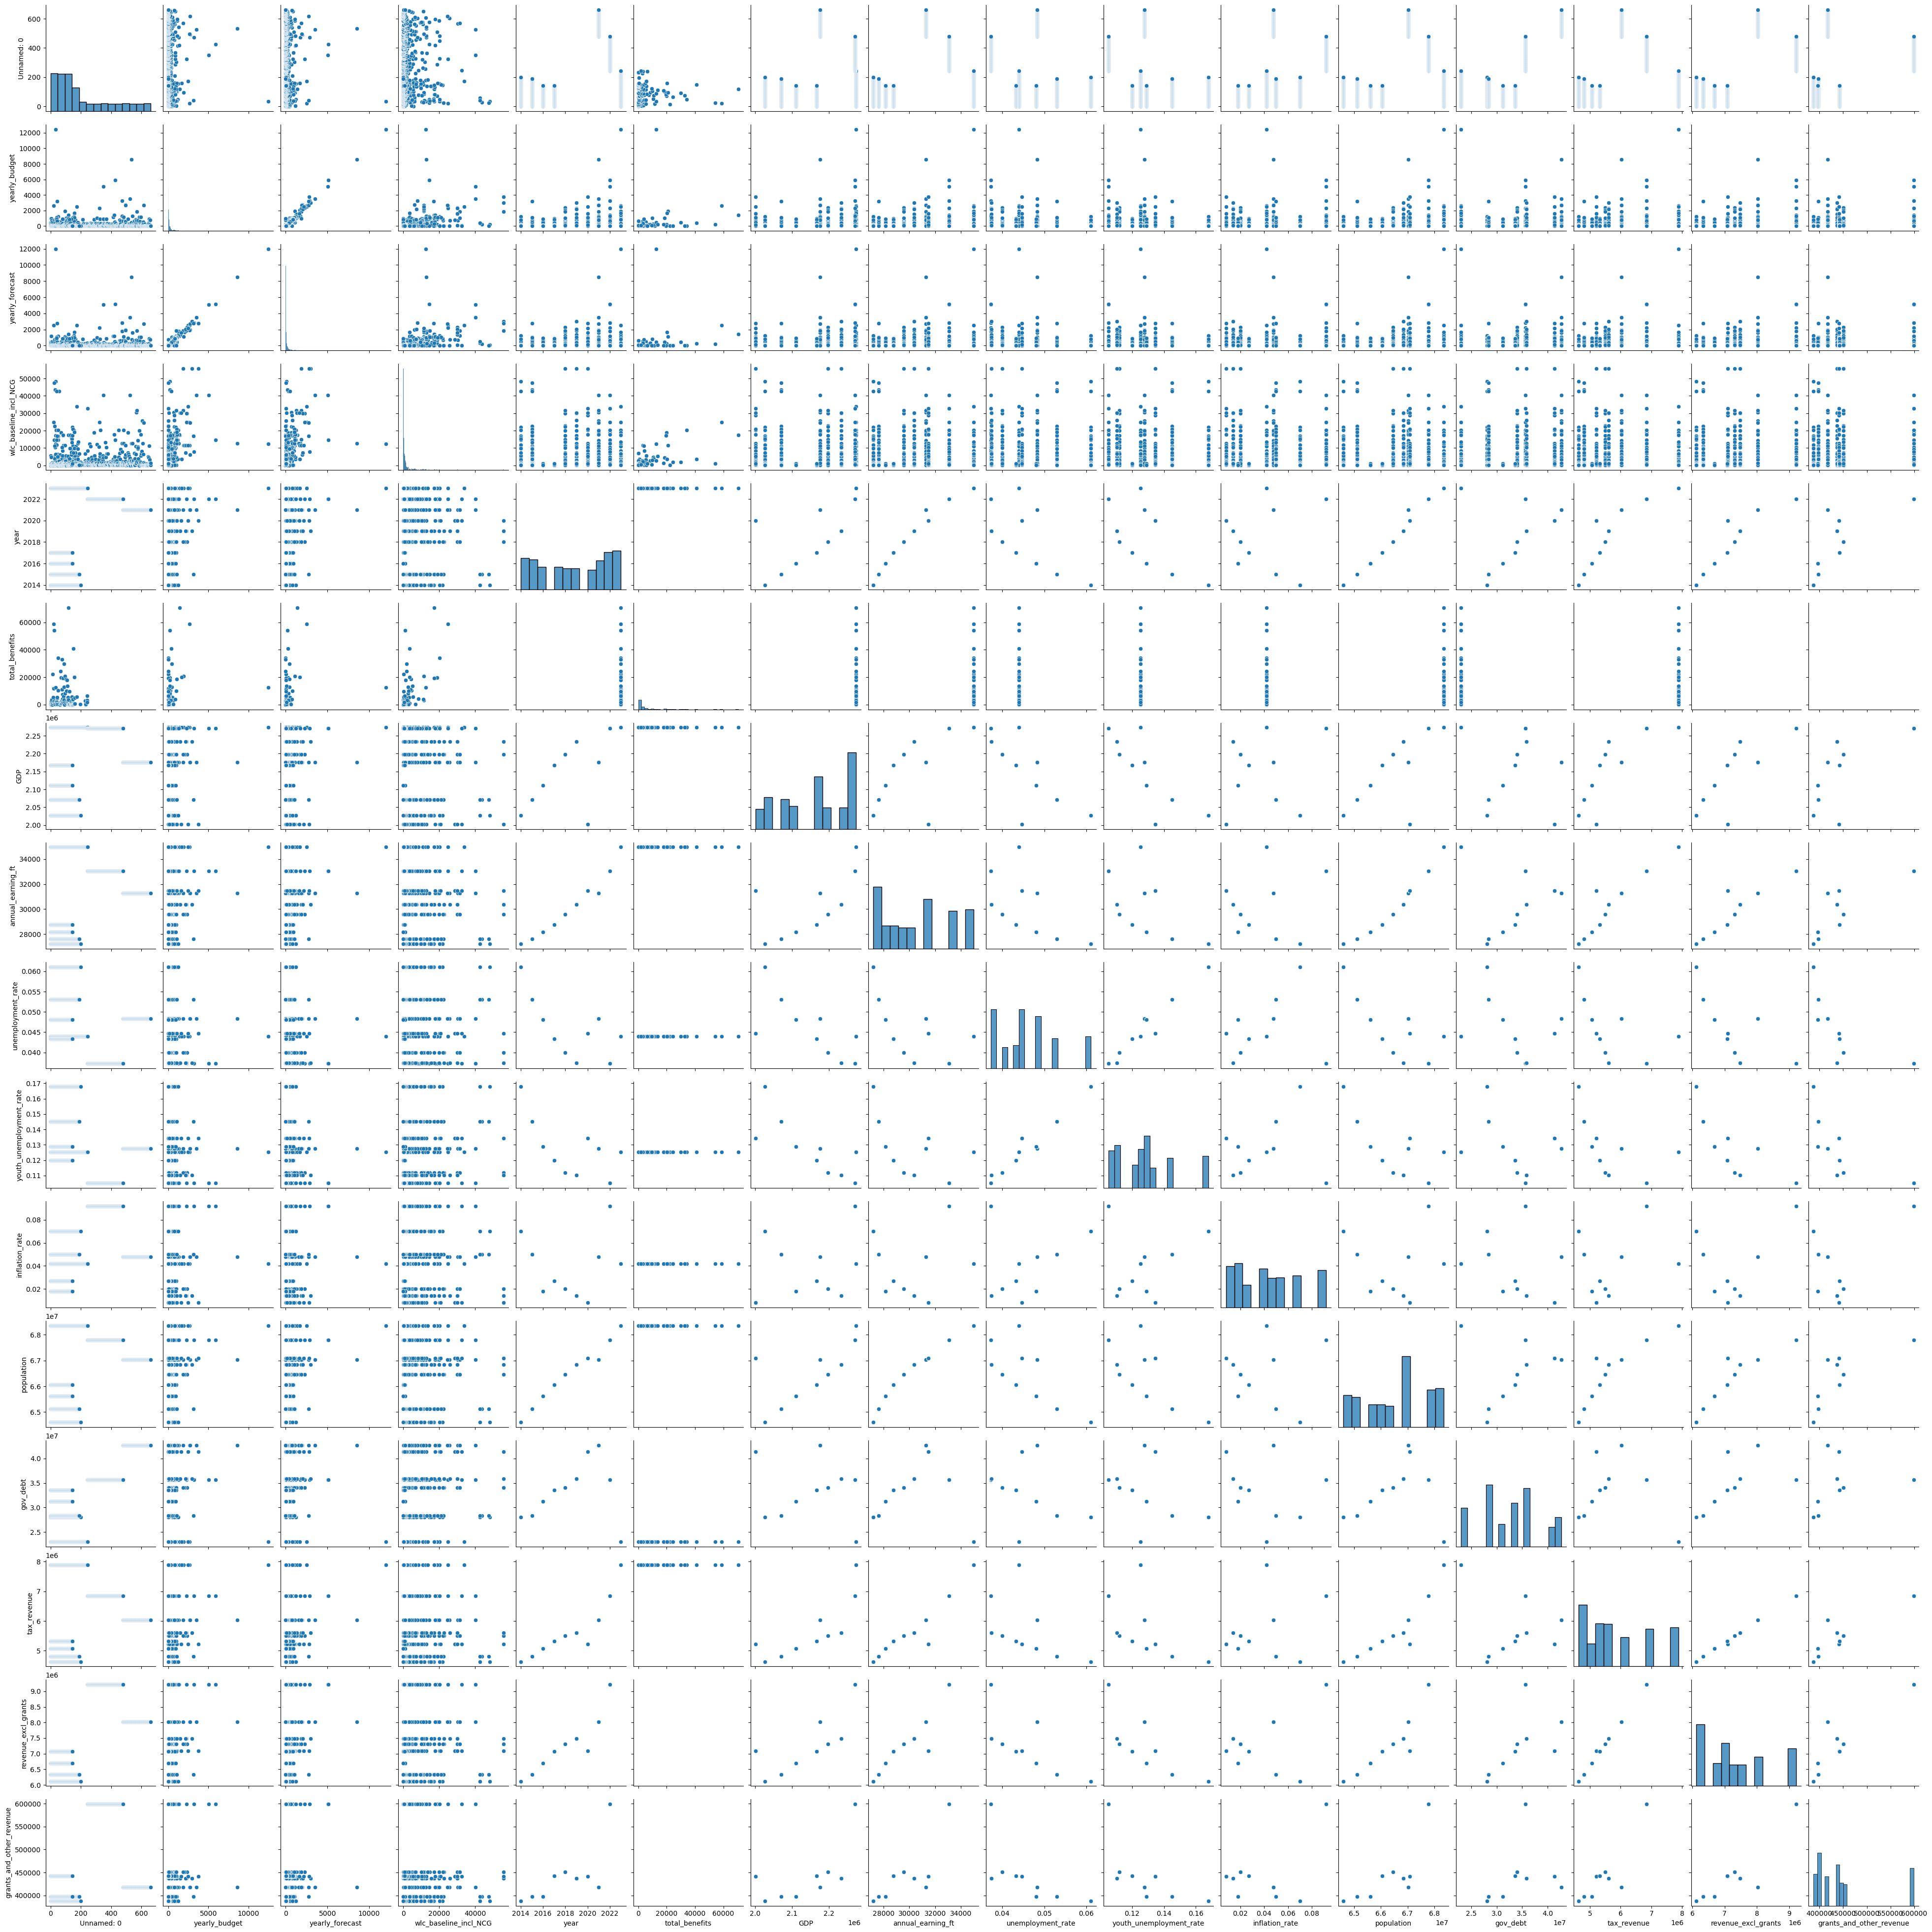

In [70]:
sns.pairplot(df)

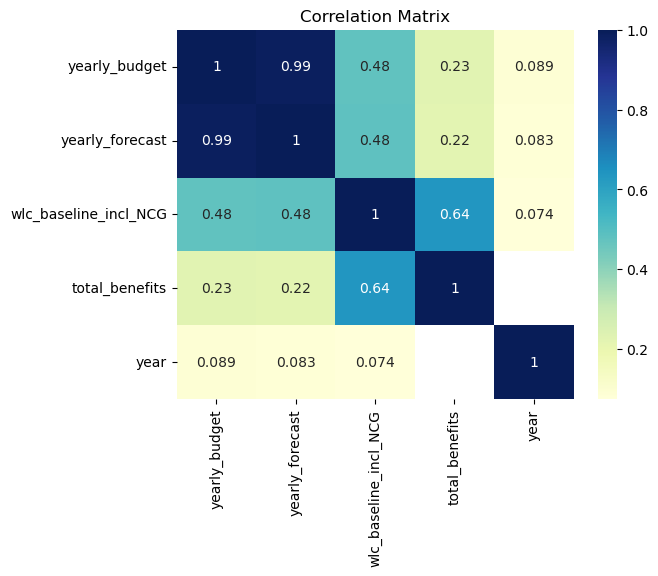

In [71]:
corr_matrix = df[["yearly_budget", "yearly_forecast", "wlc_baseline_incl_NCG", "total_benefits", "year"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.title('Correlation Matrix')
plt.show()

<Axes: >

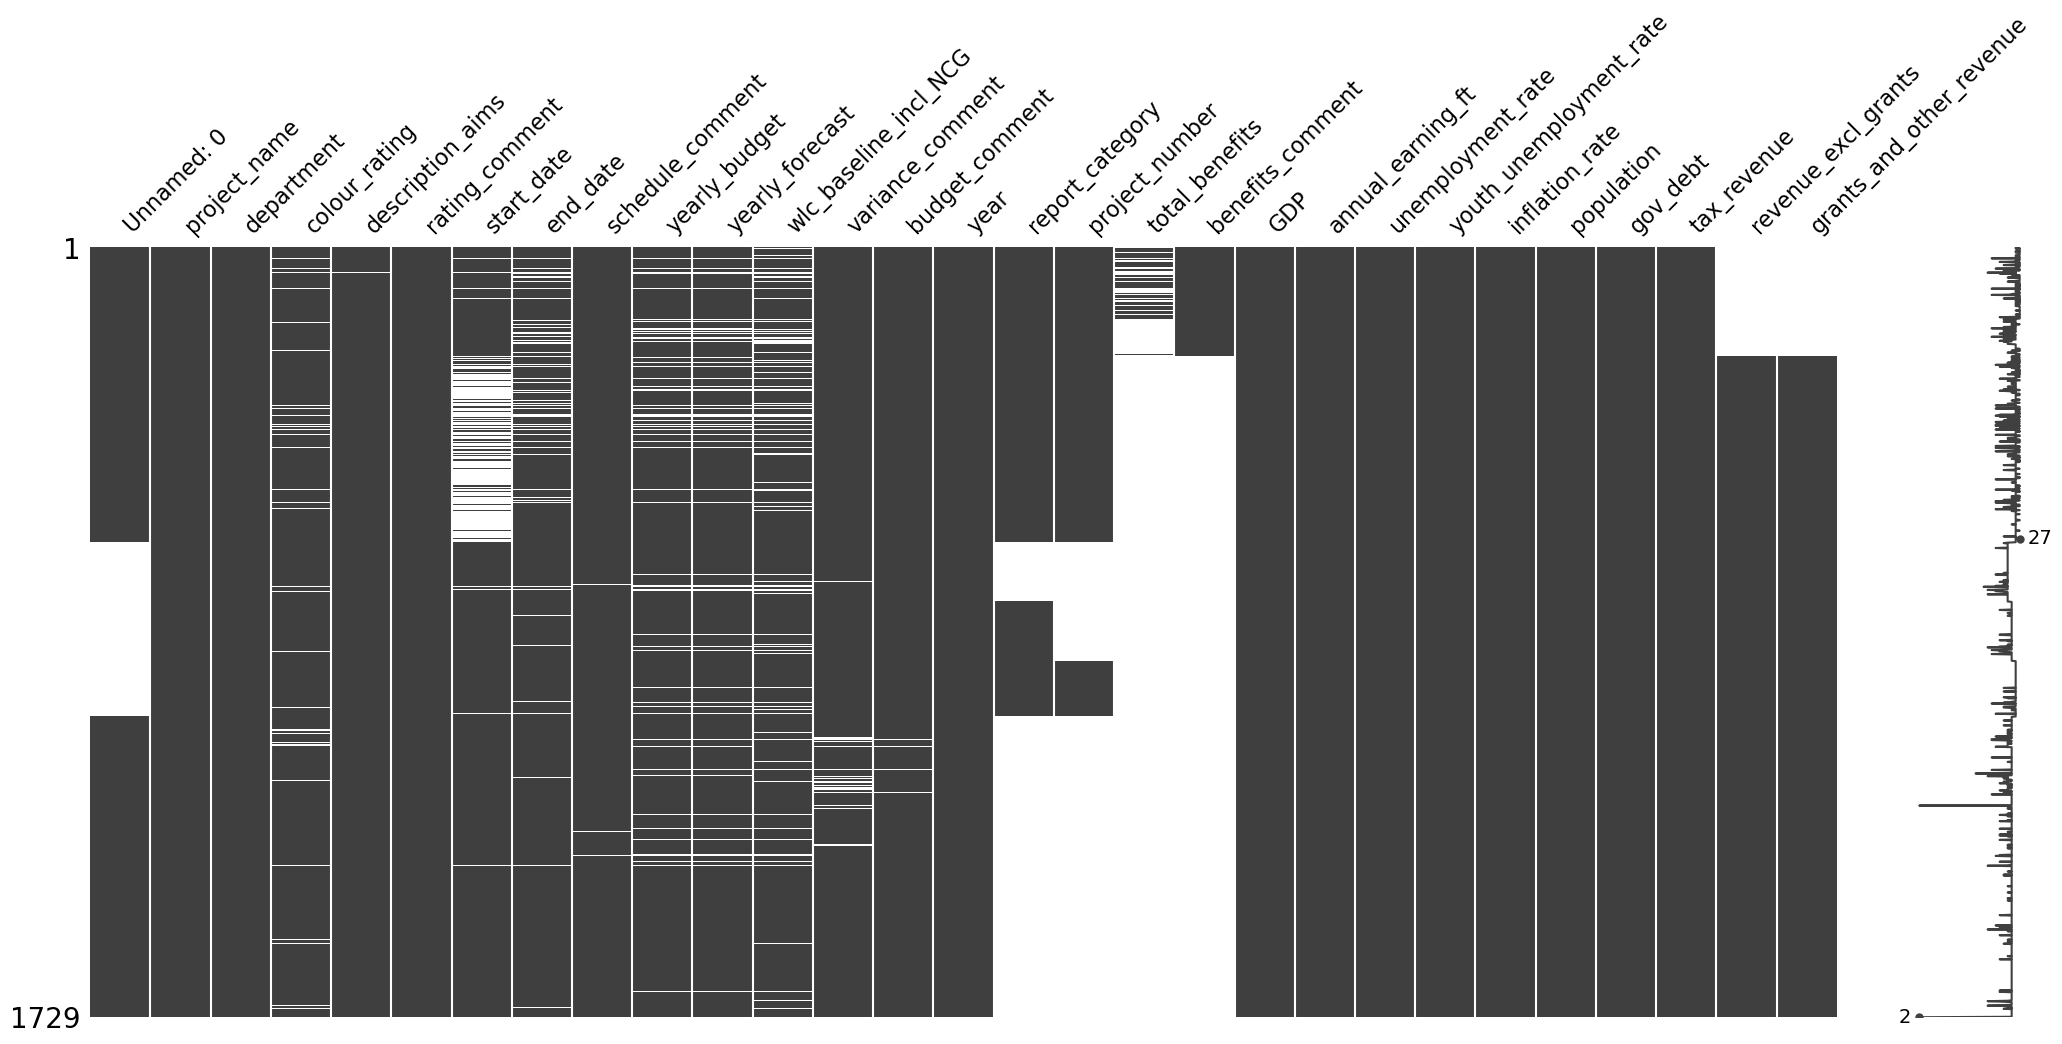

In [72]:
msn.matrix(df)

In [103]:
df["report_category"].unique()

array(['Government Transformation and Service Delivery', 'ICT',
       'Infrastructure and Construction', 'Military Capability', nan],
      dtype=object)

In [104]:
df["department"].unique()

array(['CO', 'DBT', 'DCMS', 'DEFRA', 'DESNZ', 'DFE', 'DFT', 'DHSC',
       'DLUHC', 'DSIT', 'DWP', 'FCDO', 'HMLR', 'HMRC', 'HMT', 'HO', 'MOD',
       'MOJ', 'NCA', 'ONS', 'VOA', 'BEIS', 'DEFRA & DFT', 'MHCLG', 'DfE',
       'DFID', 'DfT', 'FCO', 'MoJ', 'BIS', 'DCLG', 'DECC', 'DfID', 'DoH',
       'DOH', 'NS&I', 'CPS', 'DoH Non Capital', 'DoH Capital', 'MoD',
       'DH'], dtype=object)